question1

In [1]:
import numpy as np
def generate_poisson_spikes(rate, time, refractory_period=0):
    dt = 0.001  # time step
    n_steps = int(time / dt)
    train = np.zeros(n_steps)

    refractory_steps = int(refractory_period / dt)
    steps_since_spike = refractory_steps

    for i in range(n_steps):
        if steps_since_spike < refractory_steps:
            steps_since_spike += 1
        elif np.random.rand() < rate * dt:
            train[i] = 1
            steps_since_spike = 0

    return train

In [2]:
def compute_fano_and_cv(train, window_width):
    dt = 0.001
    window_steps = int(window_width / dt)
    counts = [np.sum(train[i:i+window_steps]) for i in range(0, len(train), window_steps)]

    fano = np.var(counts) / np.mean(counts)

    spike_times = np.nonzero(train)[0] * dt
    intervals = np.diff(spike_times)

    cv = np.std(intervals) / np.mean(intervals)

    return fano, cv

In [3]:
rate = 35
time = 1000
no_refractory_train = generate_poisson_spikes(rate, time)
refractory_train = generate_poisson_spikes(rate, time, refractory_period=5)

for window in [10, 50, 100]:
    fano, cv = compute_fano_and_cv(no_refractory_train, window)
    print(f'No refractory period - window: {window} ms, Fano factor: {fano}, Coefficient of Variation: {cv}')

for window in [10, 50, 100]:
    fano, cv = compute_fano_and_cv(refractory_train, window)
    print(f'Refractory period: 5ms - window: {window} ms, Fano factor: {fano}, Coefficient of Variation: {cv}')

No refractory period - window: 10 ms, Fano factor: 0.7427232016325607, Coefficient of Variation: 0.9793518604333229
No refractory period - window: 50 ms, Fano factor: 0.8097556827844228, Coefficient of Variation: 0.9793518604333229
No refractory period - window: 100 ms, Fano factor: 0.7233036675925402, Coefficient of Variation: 0.9793518604333229
Refractory period: 5ms - window: 10 ms, Fano factor: 0.004974874371859296, Coefficient of Variation: 0.005719569963065877
Refractory period: 5ms - window: 50 ms, Fano factor: 0.004773869346733669, Coefficient of Variation: 0.005719569963065877
Refractory period: 5ms - window: 100 ms, Fano factor: 0.004522613065326633, Coefficient of Variation: 0.005719569963065877


question2

In [4]:
def load_spike_data(filename):
    return np.loadtxt(filename)

In [5]:

spike_data = load_spike_data('rho.dat')

dt = 2 / 1000
time = len(spike_data) * dt

for window in [10, 50, 100]:
    fano, cv = compute_fano_and_cv(spike_data, window)
    print(f'Real spike train - window: {window} ms, Fano factor: {fano}, Coefficient of Variation: {cv}')

Real spike train - window: 10 ms, Fano factor: 10.148983227924854, Coefficient of Variation: 2.0085523370640965
Real spike train - window: 50 ms, Fano factor: 21.666652674390402, Coefficient of Variation: 2.0085523370640965
Real spike train - window: 100 ms, Fano factor: 15.285712953116546, Coefficient of Variation: 2.0085523370640965


question3

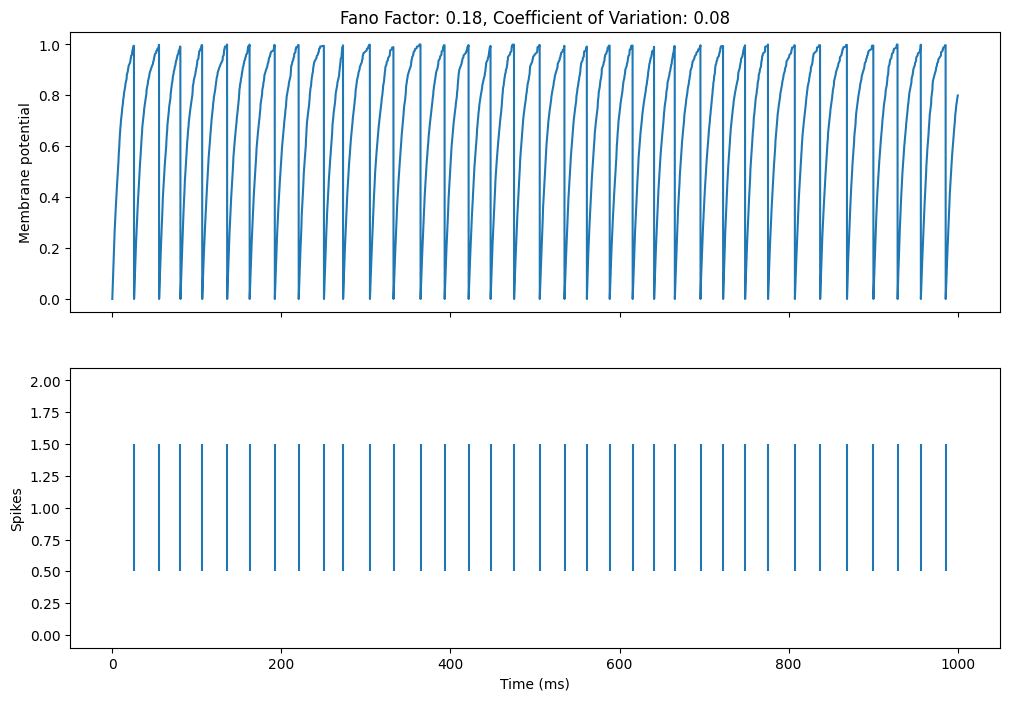

In [6]:
import numpy as np
import matplotlib.pyplot as plt

T = 1000
dt = 0.125
time = np.arange(0, T+dt, dt)
rate = 10
n_synapses = 100

inp = np.random.poisson(rate*dt/1000, (n_synapses, len(time)))

V_reset = 0
V_th = 1
tau_m = 10
I_DC = 1
stim_strength = 0.5

V = np.zeros_like(time)
spikes = np.zeros_like(time)
I = I_DC + stim_strength * inp.sum(axis=0)

for i in range(1, len(time)):
    dV = (-V[i-1] + I[i-1]) / tau_m * dt
    V[i] = V[i-1] + dV
    if V[i] > V_th:
        V[i] = V_reset
        spikes[i] = 1

spike_times = time[spikes > 0]
ISIs = np.diff(spike_times)
Fano_factor = np.var(ISIs) / np.mean(ISIs) if np.mean(ISIs) != 0 else 0
CV = np.std(ISIs) / np.mean(ISIs) if np.mean(ISIs) != 0 else 0

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(time, V)
ax[0].set_ylabel('Membrane potential')
ax[0].set_title(f'Fano Factor: {Fano_factor:.2f}, Coefficient of Variation: {CV:.2f}')
ax[1].eventplot(spike_times)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Spikes')

plt.show()

question4

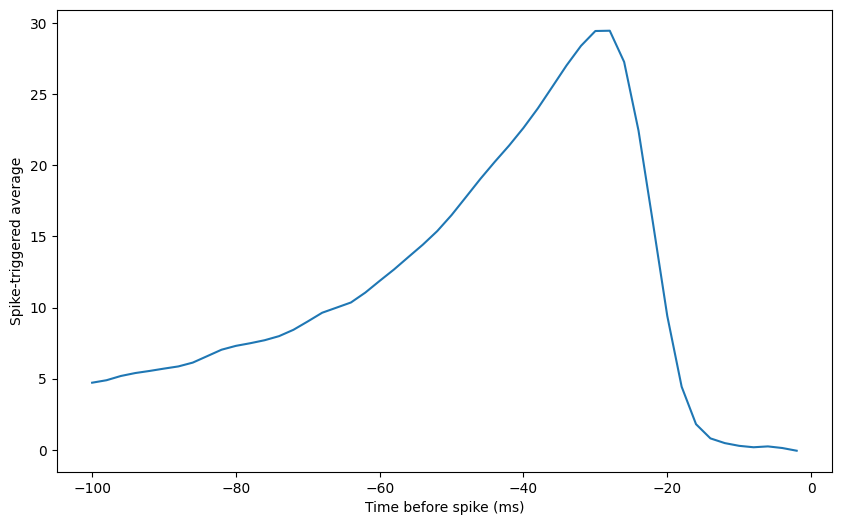

In [7]:
import numpy as np
import matplotlib.pyplot as plt

stim = np.loadtxt('stim.dat')
rho = np.loadtxt('rho.dat')

dt = 2

rho = (rho > 0).astype(int)

window_length = int(100 / dt)
sta = np.zeros(window_length)

for i in range(window_length, len(stim)):
    if rho[i] == 1:
        sta += stim[i-window_length:i]

sta /= np.sum(rho > 0)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(-window_length*dt, 0, dt), sta)
plt.xlabel('Time before spike (ms)')
plt.ylabel('Spike-triggered average')
plt.show()

question5

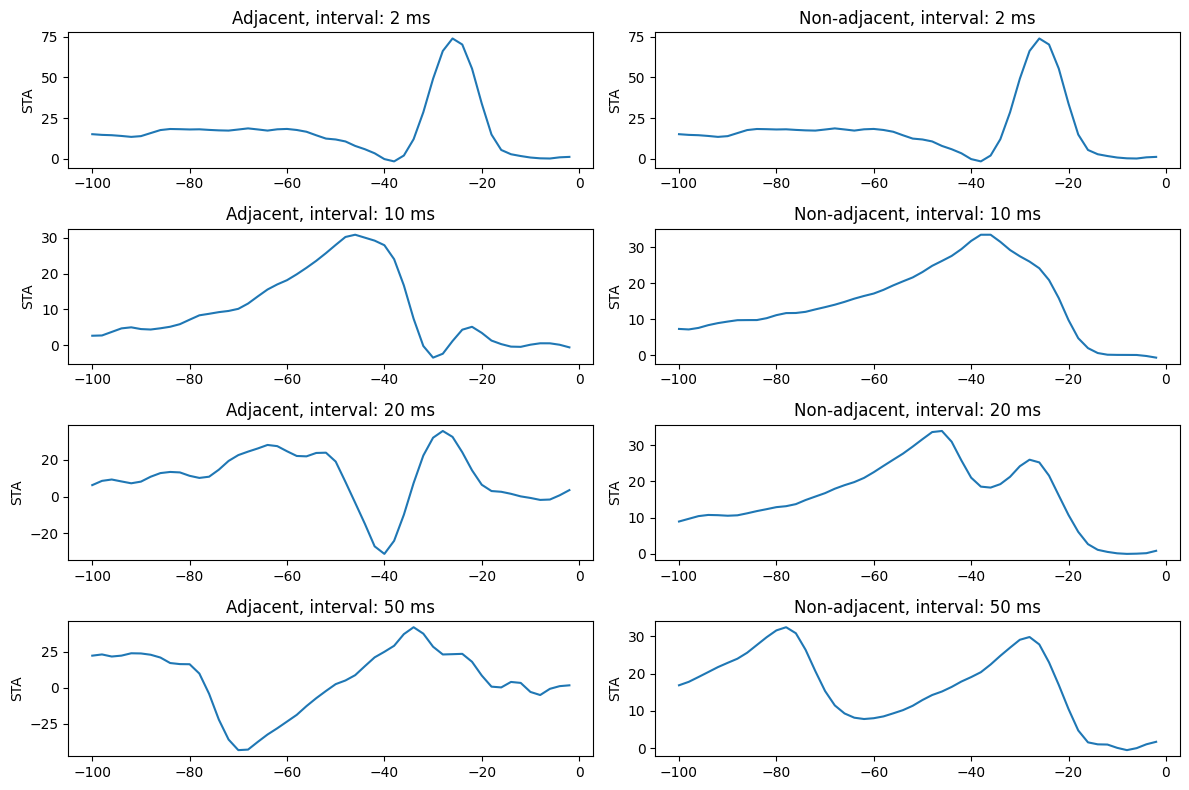

In [8]:
import numpy as np
import matplotlib.pyplot as plt

stim = np.loadtxt('stim.dat')
rho = np.loadtxt('rho.dat')

dt = 2

rho = (rho > 0).astype(int)

intervals = [int(ms / dt) for ms in [2, 10, 20, 50]]
window_length_indices = int(100 / dt)
sta_adjacent = {interval: np.zeros(window_length_indices) for interval in intervals}
sta_nonadjacent = {interval: np.zeros(window_length_indices) for interval in intervals}
counts_adjacent = {interval: 0 for interval in intervals}
counts_nonadjacent = {interval: 0 for interval in intervals}

for i in range(window_length_indices, len(stim)):
    if rho[i] == 1:
        for interval in intervals:
            if i >= interval and rho[i - interval] == 1:
                sta_nonadjacent[interval] += stim[i-window_length_indices:i]
                counts_nonadjacent[interval] += 1
                if np.all(rho[i-interval+1:i] == 0):
                    sta_adjacent[interval] += stim[i-window_length_indices:i]
                    counts_adjacent[interval] += 1

for interval in intervals:
    if counts_nonadjacent[interval] > 0:
        sta_nonadjacent[interval] /= counts_nonadjacent[interval]
    if counts_adjacent[interval] > 0:
        sta_adjacent[interval] /= counts_adjacent[interval]

fig, axs = plt.subplots(len(intervals), 2, figsize=(12, 8))
for i, interval in enumerate(intervals):
    time_axis = np.arange(-window_length_indices*dt, 0, dt)
    axs[i, 0].plot(time_axis, sta_adjacent[interval])
    axs[i, 0].set_title(f'Adjacent, interval: {interval*dt} ms')
    axs[i, 0].set_ylabel('STA')

    axs[i, 1].plot(time_axis, sta_nonadjacent[interval])
    axs[i, 1].set_title(f'Non-adjacent, interval: {interval*dt} ms')
    axs[i, 1].set_ylabel('STA')

plt.tight_layout()
plt.show()

question6:

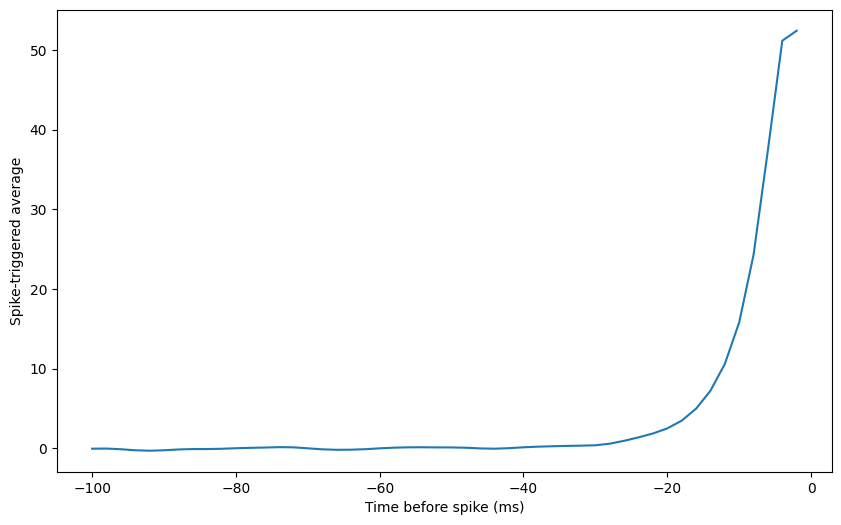

In [9]:
import numpy as np
import matplotlib.pyplot as plt

stim = np.loadtxt('stim.dat')
tau_m = 10
V_thresh = 1
V_reset = 0
I_DC = 1
stim_strength = 0.5

dt = 2
t = np.arange(0, len(stim)*dt, dt)

V_m = np.zeros_like(stim)

I = I_DC + stim_strength * stim

spikes = np.zeros_like(stim)
for i in range(1, len(stim)):
    dV = (-V_m[i-1] + I[i-1]) / tau_m * dt
    V_m[i] = V_m[i-1] + dV
    if V_m[i] > V_thresh:
        V_m[i] = V_reset
        spikes[i] = 1

window_length = int(100 / dt)
window_times = np.arange(-window_length*dt, 0, dt)
sta_windows = []

for i in range(window_length, len(stim)):
    if spikes[i] == 1:
        sta_windows.append(stim[i-window_length:i])

sta = np.mean(sta_windows, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(window_times, sta)
plt.xlabel('Time before spike (ms)')
plt.ylabel('Spike-triggered average')
plt.show()

The spike triggered average is a method of characterizing the response characteristics of neurons to a class of possible input stimuli.